# Land cover classification using ensembling technique

## Importing the necessary libraries

In [1]:
!pip install rasterio -q
!pip install optuna -q
import os
import glob
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as T
import rasterio

from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score)
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 84.3 MB/s eta 0:00:00


In [2]:
# ---------------------------
# DEVICE & REPRO
# ---------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Device: cuda


In [3]:
# ------------------ TUNABLE CONFIG ------------------
DATAPATH = "/kaggle/input/land-cover-1324536787"
CLASSES = ['AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial',
           'Pasture','PermanentCrop','Residential','River','SeaLake']


TUNING_LIMIT_PER_CLASS = 1000
FINAL_LIMIT_PER_CLASS = 3000
N_TRIALS = 20
EPOCHS_TRIAL = 6 
EPOCHS_FINAL = 50
EARLY_STOPPING_PATIENCE = 5
NUM_WORKERS = 4             # For faster data loading
MODEL_DIR = "/kaggle/working/models_ensemble"
FEATURE_DIR = "/kaggle/working/features_ensemble"
SAVE_DIR = "/kaggle/working/ensemble_outputs"
N_SAMPLE_PRED = 7
os.makedirs(MODEL_DIR, exist_ok=True); os.makedirs(FEATURE_DIR, exist_ok=True); os.makedirs(SAVE_DIR, exist_ok=True)

In [4]:
# Define training transform with advanced augmentations
train_transform = T.Compose([
    T.Lambda(lambda x: F.interpolate(x.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

# ------------------ Helpers ------------------
def safe_load_model(func, *args, **kwargs):
    try:
        return func(*args, **kwargs)
    except TypeError:
        kwargs2 = kwargs.copy()
        if "weights" in kwargs2:
            kwargs2.pop("weights")
            kwargs2["pretrained"] = True
        return func(*args, **kwargs2)

def expand_conv_in_channels(conv, new_in_channels=4):
    w = conv.weight.data
    old_in = w.size(1)
    if old_in == new_in_channels:
        return
    if old_in == 3 and new_in_channels == 4:
        new_w = torch.zeros(w.size(0), new_in_channels, w.size(2), w.size(3), device=w.device)
        new_w[:, :3, :, :] = w
        new_w[:, 3:4, :, :] = w.mean(dim=1, keepdim=True)
        conv.weight = nn.Parameter(new_w)
        conv.in_channels = new_in_channels
    else:
        new_w = torch.randn(w.size(0), new_in_channels, w.size(2), w.size(3), device=w.device) * 0.01
        conv.weight = nn.Parameter(new_w)
        conv.in_channels = new_in_channels
        print("Warning: reinitialized conv weights")

def count_params(m):
    return sum(p.numel() for p in m.parameters())

In [ ]:
# ------------------ Dataset ------------------
class LandcoverDataset(Dataset):
    def __init__(self, datapath, classes, limit_per_class=FINAL_LIMIT_PER_CLASS, transform=None):
        self.datapath = datapath
        self.classes = classes
        self.transform = transform if transform is not None else (lambda x: x)
        self.samples = []
        for ci, cname in enumerate(classes):
            folder = os.path.join(datapath, "ds", "images", "remote_sensing", "otherDatasets", "sentinel_2", "tif", cname)
            files = glob.glob(os.path.join(folder, "*.tif"))
            if not files:
                print(f"Warning: no images for class {cname} at {folder}")
                continue
            files = files[:min(limit_per_class, len(files))]
            for f in files:
                try:
                    with rasterio.open(f) as src:
                        if src.count >= 4:
                            self.samples.append({'X': f, 'Y': ci})
                except Exception as e:
                    print("Skip file:", f, e)
        if len(self.samples) == 0:
            raise RuntimeError("No samples found. Check DATAPATH and folder structure.")
        # Compute per-band mean/std over a small subset
        means, stds = [], []
        for i, s in enumerate(self.samples[:200]):
            try:
                with rasterio.open(s['X']) as src:
                    arr = src.read([1,2,3,4]).astype(np.float32)
                    means.append(arr.mean(axis=(1,2)))
                    stds.append(arr.std(axis=(1,2)))
            except:
                pass
        if means:
            self.mean = np.mean(means, axis=0).reshape(4,1,1).astype(np.float32)
            self.std = (np.mean(stds, axis=0) + 1e-8).reshape(4,1,1).astype(np.float32)
        else:
            self.mean = np.zeros((4,1,1), dtype=np.float32)
            self.std = np.ones((4,1,1), dtype=np.float32)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        p = s['X']
        y = s['Y']
        try:
            with rasterio.open(p) as src:
                arr = src.read([1,2,3,4]).astype(np.float32)
            arr = (arr - self.mean) / self.std
            arr = np.clip(arr, -5.0, 5.0)
            t = torch.from_numpy(arr)
            t = self.transform(t)
            return t, y, p
        except Exception as e:
            print("Read error:", p, e)
            return None

def custom_collate(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return None
    imgs, labs, paths = zip(*batch)
    imgs = torch.stack(imgs)
    labs = torch.tensor(labs, dtype=torch.long)
    return imgs, labs, list(paths)

def display_random_images(datapath, classes, n=10):
    fig, axes = plt.subplots(2, 5, figsize=(16,10))
    axes = axes.ravel()
    for i, cname in enumerate(classes[:n]):
        folder = os.path.join(datapath, "ds", "images", "remote_sensing", "otherDatasets", "sentinel_2", "tif", cname)
        imgs = glob.glob(os.path.join(folder, "*.tif"))
        assert len(imgs) > 0, f"No images for class {cname}"
        p = random.choice(imgs)
        with rasterio.open(p) as src:
            rgb = src.read([4,3,2]).astype(np.float32)
            mx = rgb.max() if rgb.max() > 0 else 1.0
            rgb = np.clip(rgb/mx, 0, 1)
            axes[i].imshow(rgb.transpose(1,2,0))
            axes[i].set_title(cname)
            axes[i].axis('off')
    plt.suptitle("Random samples")
    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout()
    plt.show()

# ------------------ Backbones & Wrapper ------------------
def build_feature_extractor(name, device=DEVICE):
    name = name.lower()
    if name == "shufflenet":
        base = safe_load_model(models.shufflenet_v2_x1_0, weights="IMAGENET1K_V1")
        expand_conv_in_channels(base.conv1[0], 4)
        base.fc = nn.Identity()
        feat_dim = 1024
    elif name == "mobilenet":
        base = safe_load_model(models.mobilenet_v2, weights="IMAGENET1K_V1")
        expand_conv_in_channels(base.features[0][0], 4)
        base.classifier = nn.Identity()
        feat_dim = 1280
    elif name == "efficientnet":
        base = safe_load_model(models.efficientnet_b1, weights="IMAGENET1K_V1")
        expand_conv_in_channels(base.features[0][0], 4)
        base.classifier = nn.Identity()
        feat_dim = 1280
    else:
        raise ValueError("Unknown backbone")
    base = base.to(device)
    return base, feat_dim

class BackboneProj(nn.Module):
    def __init__(self, base):
        super().__init__()
        self.base = base

    def forward(self, x):
        return self.base(x) 

In [ ]:
# ------------------ Train Projection Head ------------------
def train_proj_head(wrapper, train_loader, val_loader, epochs, lr, weight_decay, patience=5):
    # Freeze all backbone parameters
    for p in wrapper.base.parameters():
        p.requires_grad = False
    # Unfreeze last 2 layers of backbone
    if 'efficientnet' in str(type(wrapper.base)):
        for p in wrapper.base.features[-2:].parameters():
            p.requires_grad = True
    elif 'mobilenet' in str(type(wrapper.base)):
        for p in wrapper.base.features[-2:].parameters():
            p.requires_grad = True
    elif 'shufflenet' in str(type(wrapper.base)):
        for p in wrapper.base.stage4.parameters():
            p.requires_grad = True
        for p in wrapper.base.conv5.parameters():
            p.requires_grad = True
    else:
        raise ValueError("Unknown backbone structure")

    wrapper = wrapper.to(DEVICE)
    
    params = []
    if 'efficientnet' in str(type(wrapper.base)):
        second_last_module = wrapper.base.features[-2]
        last_module = wrapper.base.features[-1]
        params.append({'params': second_last_module.parameters(), 'lr': lr/100})
        params.append({'params': last_module.parameters(), 'lr': lr/10})
    elif 'mobilenet' in str(type(wrapper.base)):
        second_last_module = wrapper.base.features[-2]
        last_module = wrapper.base.features[-1]
        params.append({'params': second_last_module.parameters(), 'lr': lr/100})
        params.append({'params': last_module.parameters(), 'lr': lr/10})
    elif 'shufflenet' in str(type(wrapper.base)):
        params.append({'params': wrapper.base.stage4.parameters(), 'lr': lr/100})
        params.append({'params': wrapper.base.conv5.parameters(), 'lr': lr/10})

    opt = optim.Adam(params, lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=2, verbose=True)
    crit = nn.CrossEntropyLoss()
    best_state = None
    best_val_loss = float('inf')
    wait = 0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(epochs):
        wrapper.train()
        tloss, t_correct, n = 0.0, 0, 0
        for batch in train_loader:
            if batch is None:
                continue
            x, y, _ = batch
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            out = wrapper(x)
            loss = crit(out, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(wrapper.parameters(), max_norm=1.0)  # Gradient clipping
            opt.step()
            tloss += loss.item() * x.size(0)
            n += x.size(0)
            preds = out.argmax(dim=1)
            t_correct += (preds == y).sum().item()
        tavg = tloss / n if n > 0 else 0.0
        t_acc = t_correct / n if n > 0 else 0.0
        train_losses.append(tavg)
        train_accs.append(t_acc)
        wrapper.eval()
        vloss, v_correct, vn = 0.0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                if batch is None:
                    continue
                x, y, _ = batch
                x, y = x.to(DEVICE), y.to(DEVICE)
                out = wrapper(x)
                loss = crit(out, y)
                vloss += loss.item() * x.size(0)
                vn += x.size(0)
                preds = out.argmax(dim=1)
                v_correct += (preds == y).sum().item()
        vavg = vloss / vn if vn > 0 else float('inf')
        v_acc = v_correct / vn if vn > 0 else 0.0
        val_losses.append(vavg)
        val_accs.append(v_acc)
        scheduler.step(vavg)
        print(f"[proj] epoch {epoch+1}/{epochs} train_loss={tavg:.4f} train_acc={t_acc:.4f} val_loss={vavg:.4f} val_acc={v_acc:.4f}")
        if vavg < best_val_loss - 1e-6:
            best_val_loss = vavg
            best_state = {k: v.cpu().clone() for k, v in wrapper.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping proj head")
                break
    if best_state:
        wrapper.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})
    return wrapper, train_losses, val_losses, train_accs, val_accs

# ------------------ Extract Features ------------------
def extract_features(wrapper, loader):
    wrapper.eval()
    feats, labs = [], []
    with torch.no_grad():
        for batch in loader:
            if batch is None:
                continue
            x, y, _ = batch
            out = wrapper(x.to(DEVICE))
            feats.append(out.cpu().numpy())
            labs.append(y.numpy())
    if feats:
        return np.concatenate(feats, axis=0), np.concatenate(labs, axis=0)
    return np.zeros((0, wrapper.base.fc.out_features if hasattr(wrapper.base, 'fc') else wrapper.base.classifier.out_features)), np.zeros((0,), dtype=int)

# ------------------ Meta Classifier ------------------
class MetaNet(nn.Module):
    def __init__(self, in_dim, n_classes=10, dropout=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, n_classes)
        )
    def forward(self, x):
        return self.net(x)

def train_meta(meta, Xtr, ytr, Xv, yv, epochs, batch_size, lr, weight_decay, patience=5):
    meta = meta.to(DEVICE)
    opt = optim.Adam(meta.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=2, verbose=True)
    crit = nn.CrossEntropyLoss()
    train_ds = torch.utils.data.TensorDataset(torch.from_numpy(Xtr).float(), torch.from_numpy(ytr).long())
    val_ds = torch.utils.data.TensorDataset(torch.from_numpy(Xv).float(), torch.from_numpy(yv).long())
    tr_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    best_state = None
    best_val = float('inf')
    wait = 0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(epochs):
        meta.train()
        tloss, t_correct, n = 0.0, 0, 0
        for xb, yb in tr_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            loss = crit(meta(xb), yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(meta.parameters(), max_norm=1.0)  # Gradient clipping
            opt.step()
            tloss += loss.item() * xb.size(0)
            n += xb.size(0)
            preds = meta(xb).argmax(dim=1)
            t_correct += (preds == yb).sum().item()
        tavg = tloss / n if n > 0 else 0.0
        t_acc = t_correct / n if n > 0 else 0.0
        train_losses.append(tavg)
        train_accs.append(t_acc)
        meta.eval()
        vloss, v_correct, vn = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                loss = crit(meta(xb), yb)
                vloss += loss.item() * xb.size(0)
                vn += xb.size(0)
                preds = meta(xb).argmax(dim=1)
                v_correct += (preds == yb).sum().item()
        vavg = vloss / vn if vn > 0 else float('inf')
        v_acc = v_correct / vn if vn > 0 else 0.0
        val_losses.append(vavg)
        val_accs.append(v_acc)
        print(f"[meta] epoch {epoch+1}/{epochs} train_loss={tavg:.4f} train_acc={t_acc:.4f} val_loss={vavg:.4f} val_acc={v_acc:.4f}")
        scheduler.step(vavg)
        if vavg < best_val - 1e-6:
            best_val = vavg
            best_state = {k: v.cpu().clone() for k, v in meta.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping meta")
                break
    if best_state:
        meta.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})
    return meta, train_losses, val_losses, train_accs, val_accs

# ------------------ Optuna Objective ------------------
def optuna_objective(trial, trainval_subset):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-7, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    meta_dropout = trial.suggest_float("meta_dropout", 0.1, 0.5)

    labels = [trainval_subset[i][1] for i in range(len(trainval_subset))]
    t_idx, v_idx = train_test_split(list(range(len(trainval_subset))), test_size=0.2, stratify=labels, random_state=SEED)
    tr_sub = Subset(trainval_subset.dataset, [trainval_subset.indices[i] for i in t_idx])
    val_sub = Subset(trainval_subset.dataset, [trainval_subset.indices[i] for i in v_idx])
    tr_sub.dataset.transform = train_transform
    val_sub.dataset.transform = lambda x: x
    tr_loader = DataLoader(tr_sub, batch_size=batch_size, shuffle=True, collate_fn=custom_collate, num_workers=0)
    val_loader = DataLoader(val_sub, batch_size=batch_size, shuffle=False, collate_fn=custom_collate, num_workers=0)

    backbone_names = ["shufflenet", "mobilenet", "efficientnet"]
    feats_tr, feats_val, last_y = [], [], None
    for name in backbone_names:
        base, feat_dim = build_feature_extractor(name, device=DEVICE)
        wrapper = BackboneProj(base).to(DEVICE)
        wrapper, _, _, _, _ = train_proj_head(wrapper, tr_loader, val_loader, epochs=EPOCHS_TRIAL, lr=lr, weight_decay=weight_decay, patience=2)
        fval, yval = extract_features(wrapper, val_loader)
        ftr, ytr = extract_features(wrapper, tr_loader)
        feats_val.append(fval)
        feats_tr.append(ftr)
        last_y = yval
        del base, wrapper
        torch.cuda.empty_cache()

    Xtr = np.concatenate(feats_tr, axis=1)
    Xv = np.concatenate(feats_val, axis=1)
    meta = MetaNet(in_dim=Xtr.shape[1], n_classes=len(CLASSES), dropout=meta_dropout)
    meta, _, _, _, _ = train_meta(meta, Xtr, ytr, Xv, last_y, epochs=EPOCHS_TRIAL, batch_size=batch_size, lr=lr, weight_decay=weight_decay, patience=2)

    meta.eval()
    with torch.no_grad():
        preds = meta(torch.from_numpy(Xv).float().to(DEVICE)).argmax(dim=1).cpu().numpy()
    acc = (preds == last_y).mean()
    return acc

# ------------------ Final Ensemble Model ------------------
class FinalEnhancedEnsembleModel(nn.Module):
    def __init__(self, wrappers, meta):
        super().__init__()
        self.wrappers = nn.ModuleList(wrappers)
        self.meta = meta

    def forward(self, x):
        features = [wrapper(x) for wrapper in self.wrappers]
        stacked = torch.cat(features, dim=1)
        return self.meta(stacked)

def train_ensemble(ensemble, train_loader, val_loader, epochs, lr, weight_decay, patience=5):
    ensemble = ensemble.to(DEVICE)
    opt = optim.Adam(ensemble.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=2, verbose=True)
    crit = nn.CrossEntropyLoss()
    best_state = None
    best_val_loss = float('inf')
    wait = 0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(epochs):
        ensemble.train()
        tloss, t_correct, n = 0.0, 0, 0
        for batch in train_loader:
            if batch is None:
                continue
            x, y, _ = batch
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            out = ensemble(x)
            loss = crit(out, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(ensemble.parameters(), max_norm=1.0)  # Gradient clipping
            opt.step()
            tloss += loss.item() * x.size(0)
            n += x.size(0)
            preds = out.argmax(dim=1)
            t_correct += (preds == y).sum().item()
        tavg = tloss / n if n > 0 else 0.0
        t_acc = t_correct / n if n > 0 else 0.0
        train_losses.append(tavg)
        train_accs.append(t_acc)
        ensemble.eval()
        vloss, v_correct, vn = 0.0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                if batch is None:
                    continue
                x, y, _ = batch
                x, y = x.to(DEVICE), y.to(DEVICE)
                out = ensemble(x)
                loss = crit(out, y)
                vloss += loss.item() * x.size(0)
                vn += x.size(0)
                preds = out.argmax(dim=1)
                v_correct += (preds == y).sum().item()
        vavg = vloss / vn if vn > 0 else float('inf')
        v_acc = v_correct / vn if vn > 0 else 0.0
        val_losses.append(vavg)
        val_accs.append(v_acc)
        print(f"[ensemble] epoch {epoch+1}/{epochs} train_loss={tavg:.4f} train_acc={t_acc:.4f} val_loss={vavg:.4f} val_acc={v_acc:.4f}")
        scheduler.step(vavg)
        if vavg < best_val_loss - 1e-6:
            best_val_loss = vavg
            best_state = {k: v.cpu().clone() for k, v in ensemble.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping ensemble")
                break
    if best_state:
        ensemble.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})
    return ensemble, train_losses, val_losses, train_accs, val_accs

[I 2025-08-16 04:38:32,058] A new study created in memory with name: no-name-88e0fa8e-8bcb-45d0-8fb1-85778451491a


Tuning samples: 10000
Optuna trials: 20


Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 94.1MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/6 train_loss=6.9340 train_acc=0.0010 val_loss=6.9346 val_acc=0.0006
[proj] epoch 2/6 train_loss=6.9337 train_acc=0.0007 val_loss=6.9344 val_acc=0.0006
[proj] epoch 3/6 train_loss=6.9336 train_acc=0.0011 val_loss=6.9328 val_acc=0.0011
[proj] epoch 4/6 train_loss=6.9325 train_acc=0.0007 val_loss=6.9323 val_acc=0.0006
[proj] epoch 5/6 train_loss=6.9319 train_acc=0.0010 val_loss=6.9300 val_acc=0.0017
[proj] epoch 6/6 train_loss=6.9312 train_acc=0.0011 val_loss=6.9319 val_acc=0.0022


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 108MB/s] 


[proj] epoch 1/6 train_loss=7.5171 train_acc=0.0017 val_loss=7.6112 val_acc=0.0044
[proj] epoch 2/6 train_loss=7.4815 train_acc=0.0013 val_loss=7.4896 val_acc=0.0028
[proj] epoch 3/6 train_loss=7.4459 train_acc=0.0019 val_loss=7.4904 val_acc=0.0039
[proj] epoch 4/6 train_loss=7.4110 train_acc=0.0022 val_loss=7.5182 val_acc=0.0050
Early stopping proj head


Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 129MB/s]


[proj] epoch 1/6 train_loss=7.7385 train_acc=0.0007 val_loss=8.1107 val_acc=0.0000
[proj] epoch 2/6 train_loss=7.7175 train_acc=0.0004 val_loss=8.1225 val_acc=0.0000
[proj] epoch 3/6 train_loss=7.7210 train_acc=0.0004 val_loss=8.0628 val_acc=0.0006
[proj] epoch 4/6 train_loss=7.7243 train_acc=0.0003 val_loss=8.1471 val_acc=0.0006
[proj] epoch 5/6 train_loss=7.7068 train_acc=0.0004 val_loss=8.1249 val_acc=0.0006
Early stopping proj head
[meta] epoch 1/6 train_loss=2.2869 train_acc=0.1528 val_loss=2.2680 val_acc=0.2439
[meta] epoch 2/6 train_loss=2.2131 train_acc=0.3025 val_loss=2.1785 val_acc=0.3706
[meta] epoch 3/6 train_loss=2.0915 train_acc=0.4458 val_loss=2.0501 val_acc=0.4761
[meta] epoch 4/6 train_loss=1.9397 train_acc=0.5347 val_loss=1.9033 val_acc=0.5389
[meta] epoch 5/6 train_loss=1.7844 train_acc=0.5850 val_loss=1.7455 val_acc=0.6072


[I 2025-08-16 04:56:37,613] Trial 0 finished with value: 0.6327777777777778 and parameters: {'lr': 1.0363831780981874e-05, 'weight_decay': 4.387213731398029e-07, 'batch_size': 16, 'meta_dropout': 0.11134552334375872}. Best is trial 0 with value: 0.6327777777777778.


[meta] epoch 6/6 train_loss=1.6298 train_acc=0.6299 val_loss=1.6051 val_acc=0.6328


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/6 train_loss=6.9345 train_acc=0.0011 val_loss=6.9338 val_acc=0.0006
[proj] epoch 2/6 train_loss=6.9345 train_acc=0.0006 val_loss=6.9323 val_acc=0.0011
[proj] epoch 3/6 train_loss=6.9334 train_acc=0.0007 val_loss=6.9341 val_acc=0.0011
[proj] epoch 4/6 train_loss=6.9328 train_acc=0.0007 val_loss=6.9323 val_acc=0.0022
Early stopping proj head
[proj] epoch 1/6 train_loss=7.5119 train_acc=0.0017 val_loss=7.6713 val_acc=0.0028
[proj] epoch 2/6 train_loss=7.4813 train_acc=0.0011 val_loss=7.5102 val_acc=0.0022
[proj] epoch 3/6 train_loss=7.4416 train_acc=0.0029 val_loss=7.5594 val_acc=0.0050
[proj] epoch 4/6 train_loss=7.4061 train_acc=0.0018 val_loss=7.5682 val_acc=0.0033
Early stopping proj head
[proj] epoch 1/6 train_loss=7.7282 train_acc=0.0007 val_loss=8.2276 val_acc=0.0000
[proj] epoch 2/6 train_loss=7.7231 train_acc=0.0004 val_loss=8.1688 val_acc=0.0000
[proj] epoch 3/6 train_loss=7.7120 train_acc=0.0006 val_loss=8.1345 val_acc=0.0006
[proj] epoch 4/6 train_loss=7.7112 tr

[I 2025-08-16 05:12:24,468] Trial 1 finished with value: 0.5738888888888889 and parameters: {'lr': 1.0722056036900392e-05, 'weight_decay': 3.750605392203946e-06, 'batch_size': 16, 'meta_dropout': 0.4457550068234819}. Best is trial 0 with value: 0.6327777777777778.


[meta] epoch 6/6 train_loss=2.0058 train_acc=0.3829 val_loss=1.9271 val_acc=0.5739


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/6 train_loss=6.9055 train_acc=0.0581 val_loss=6.8801 val_acc=0.1072
[proj] epoch 2/6 train_loss=6.8254 train_acc=0.3190 val_loss=6.7639 val_acc=0.3867
[proj] epoch 3/6 train_loss=6.7177 train_acc=0.4925 val_loss=6.6190 val_acc=0.6228
[proj] epoch 4/6 train_loss=6.6131 train_acc=0.5692 val_loss=6.4715 val_acc=0.6850
[proj] epoch 5/6 train_loss=6.5141 train_acc=0.6028 val_loss=6.3628 val_acc=0.7239
[proj] epoch 6/6 train_loss=6.4239 train_acc=0.6215 val_loss=6.2419 val_acc=0.7372
[proj] epoch 1/6 train_loss=6.6048 train_acc=0.0642 val_loss=5.9041 val_acc=0.1739
[proj] epoch 2/6 train_loss=5.6279 train_acc=0.3675 val_loss=4.8257 val_acc=0.6322
[proj] epoch 3/6 train_loss=5.2183 train_acc=0.5489 val_loss=4.4095 val_acc=0.7589
[proj] epoch 4/6 train_loss=4.9432 train_acc=0.6021 val_loss=4.3166 val_acc=0.7772
[proj] epoch 5/6 train_loss=4.7561 train_acc=0.6125 val_loss=4.2317 val_acc=0.7650
[proj] epoch 6/6 train_loss=4.5527 train_acc=0.6310 val_loss=4.0944 val_acc=0.7606
[pro

[I 2025-08-16 05:33:37,000] Trial 2 finished with value: 0.65 and parameters: {'lr': 0.0004836340922353233, 'weight_decay': 4.904985800930802e-07, 'batch_size': 8, 'meta_dropout': 0.2555611773532172}. Best is trial 2 with value: 0.65.


[meta] epoch 3/6 train_loss=0.8111 train_acc=0.7692 val_loss=1.1103 val_acc=0.6472
Early stopping meta


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/6 train_loss=6.9147 train_acc=0.0142 val_loss=6.8882 val_acc=0.0372
[proj] epoch 2/6 train_loss=6.8394 train_acc=0.1839 val_loss=6.7835 val_acc=0.2817
[proj] epoch 3/6 train_loss=6.7222 train_acc=0.4692 val_loss=6.6373 val_acc=0.5883
[proj] epoch 4/6 train_loss=6.6097 train_acc=0.6318 val_loss=6.5148 val_acc=0.7050
[proj] epoch 5/6 train_loss=6.5108 train_acc=0.6935 val_loss=6.3978 val_acc=0.7578
[proj] epoch 6/6 train_loss=6.4243 train_acc=0.7168 val_loss=6.2722 val_acc=0.7922
[proj] epoch 1/6 train_loss=6.5891 train_acc=0.0564 val_loss=5.7017 val_acc=0.1756
[proj] epoch 2/6 train_loss=5.4627 train_acc=0.3651 val_loss=4.8448 val_acc=0.6667
[proj] epoch 3/6 train_loss=4.9737 train_acc=0.6260 val_loss=4.4367 val_acc=0.7811
[proj] epoch 4/6 train_loss=4.6881 train_acc=0.6954 val_loss=4.2139 val_acc=0.8200
[proj] epoch 5/6 train_loss=4.4923 train_acc=0.7178 val_loss=3.9584 val_acc=0.8311
[proj] epoch 6/6 train_loss=4.3423 train_acc=0.7383 val_loss=3.8461 val_acc=0.8439
[pro

[I 2025-08-16 05:52:09,922] Trial 3 finished with value: 0.7016666666666667 and parameters: {'lr': 0.0005608984863265916, 'weight_decay': 0.00045942585945132463, 'batch_size': 16, 'meta_dropout': 0.23957076358318916}. Best is trial 3 with value: 0.7016666666666667.


[meta] epoch 6/6 train_loss=0.6317 train_acc=0.8179 val_loss=0.9542 val_acc=0.7017


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/6 train_loss=6.8163 train_acc=0.2757 val_loss=6.6019 val_acc=0.6806
[proj] epoch 2/6 train_loss=6.4561 train_acc=0.7511 val_loss=6.2452 val_acc=0.8239
[proj] epoch 3/6 train_loss=6.1677 train_acc=0.8049 val_loss=5.9556 val_acc=0.8561
[proj] epoch 4/6 train_loss=5.9220 train_acc=0.8310 val_loss=5.6887 val_acc=0.8661
[proj] epoch 5/6 train_loss=5.7000 train_acc=0.8349 val_loss=5.4461 val_acc=0.8878
[proj] epoch 6/6 train_loss=5.4732 train_acc=0.8500 val_loss=5.1923 val_acc=0.8900
[proj] epoch 1/6 train_loss=5.5178 train_acc=0.3731 val_loss=4.3931 val_acc=0.7867
[proj] epoch 2/6 train_loss=4.3079 train_acc=0.7794 val_loss=3.8465 val_acc=0.8617
[proj] epoch 3/6 train_loss=3.8337 train_acc=0.8154 val_loss=3.5342 val_acc=0.8683
[proj] epoch 4/6 train_loss=3.5161 train_acc=0.8351 val_loss=3.3308 val_acc=0.8756
[proj] epoch 5/6 train_loss=3.3063 train_acc=0.8351 val_loss=3.0440 val_acc=0.8761
[proj] epoch 6/6 train_loss=3.1440 train_acc=0.8439 val_loss=2.9436 val_acc=0.8828
[pro

[I 2025-08-16 06:09:05,223] Trial 4 finished with value: 0.8272222222222222 and parameters: {'lr': 0.002657902167250334, 'weight_decay': 3.196358232151042e-07, 'batch_size': 32, 'meta_dropout': 0.28337410994479306}. Best is trial 4 with value: 0.8272222222222222.


[meta] epoch 4/6 train_loss=0.4756 train_acc=0.8762 val_loss=0.6206 val_acc=0.8250
Early stopping meta


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/6 train_loss=6.9318 train_acc=0.0013 val_loss=6.9254 val_acc=0.0017
[proj] epoch 2/6 train_loss=6.9196 train_acc=0.0043 val_loss=6.9149 val_acc=0.0072
[proj] epoch 3/6 train_loss=6.9033 train_acc=0.0175 val_loss=6.8978 val_acc=0.0261
[proj] epoch 4/6 train_loss=6.8826 train_acc=0.0524 val_loss=6.8729 val_acc=0.0722
[proj] epoch 5/6 train_loss=6.8573 train_acc=0.1233 val_loss=6.8410 val_acc=0.1439
[proj] epoch 6/6 train_loss=6.8308 train_acc=0.2079 val_loss=6.8200 val_acc=0.2144
[proj] epoch 1/6 train_loss=7.2451 train_acc=0.0121 val_loss=6.8052 val_acc=0.0433
[proj] epoch 2/6 train_loss=6.6491 train_acc=0.0460 val_loss=6.2442 val_acc=0.1122
[proj] epoch 3/6 train_loss=6.1531 train_acc=0.0894 val_loss=5.8368 val_acc=0.1878
[proj] epoch 4/6 train_loss=5.8054 train_acc=0.1581 val_loss=5.4787 val_acc=0.2672
[proj] epoch 5/6 train_loss=5.4810 train_acc=0.2636 val_loss=5.2543 val_acc=0.3556
[proj] epoch 6/6 train_loss=5.2667 train_acc=0.3890 val_loss=4.9554 val_acc=0.5289
[pro

[I 2025-08-16 06:26:05,246] Trial 5 finished with value: 0.7366666666666667 and parameters: {'lr': 0.00022046858003580935, 'weight_decay': 0.00016392459450103005, 'batch_size': 32, 'meta_dropout': 0.4430379066134992}. Best is trial 4 with value: 0.8272222222222222.


[meta] epoch 6/6 train_loss=0.5892 train_acc=0.8250 val_loss=0.8301 val_acc=0.7200
Early stopping meta


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/6 train_loss=6.9157 train_acc=0.0192 val_loss=6.8912 val_acc=0.0556
[proj] epoch 2/6 train_loss=6.8551 train_acc=0.1982 val_loss=6.8161 val_acc=0.2944
[proj] epoch 3/6 train_loss=6.7668 train_acc=0.4386 val_loss=6.7091 val_acc=0.5694
[proj] epoch 4/6 train_loss=6.6675 train_acc=0.5990 val_loss=6.5691 val_acc=0.6961
[proj] epoch 5/6 train_loss=6.5807 train_acc=0.6579 val_loss=6.5042 val_acc=0.7378
[proj] epoch 6/6 train_loss=6.5024 train_acc=0.6871 val_loss=6.3985 val_acc=0.7689
[proj] epoch 1/6 train_loss=6.7017 train_acc=0.0435 val_loss=5.9851 val_acc=0.1183
[proj] epoch 2/6 train_loss=5.6461 train_acc=0.2376 val_loss=4.9156 val_acc=0.4628
[proj] epoch 3/6 train_loss=5.1221 train_acc=0.5271 val_loss=4.4227 val_acc=0.7233
[proj] epoch 4/6 train_loss=4.8543 train_acc=0.6457 val_loss=4.2613 val_acc=0.7883
[proj] epoch 5/6 train_loss=4.6453 train_acc=0.6903 val_loss=4.0663 val_acc=0.8267
[proj] epoch 6/6 train_loss=4.4602 train_acc=0.7231 val_loss=4.0567 val_acc=0.8139
[pro

[I 2025-08-16 06:44:44,267] Trial 6 finished with value: 0.6877777777777778 and parameters: {'lr': 0.00047346352921419187, 'weight_decay': 1.3077165350612052e-07, 'batch_size': 16, 'meta_dropout': 0.11832597002987928}. Best is trial 4 with value: 0.8272222222222222.


[meta] epoch 4/6 train_loss=0.3813 train_acc=0.9058 val_loss=1.1059 val_acc=0.6822
Early stopping meta


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/6 train_loss=6.9277 train_acc=0.0028 val_loss=6.9197 val_acc=0.0044
[proj] epoch 2/6 train_loss=6.9057 train_acc=0.0272 val_loss=6.8981 val_acc=0.0350
[proj] epoch 3/6 train_loss=6.8766 train_acc=0.1260 val_loss=6.8632 val_acc=0.1511
[proj] epoch 4/6 train_loss=6.8405 train_acc=0.2524 val_loss=6.8273 val_acc=0.2767
[proj] epoch 5/6 train_loss=6.8025 train_acc=0.3750 val_loss=6.7756 val_acc=0.3944
[proj] epoch 6/6 train_loss=6.7583 train_acc=0.4668 val_loss=6.7197 val_acc=0.5428
[proj] epoch 1/6 train_loss=7.0942 train_acc=0.0160 val_loss=6.6852 val_acc=0.0433
[proj] epoch 2/6 train_loss=6.3276 train_acc=0.0769 val_loss=5.9953 val_acc=0.1089
[proj] epoch 3/6 train_loss=5.8516 train_acc=0.1522 val_loss=5.4913 val_acc=0.2394
[proj] epoch 4/6 train_loss=5.4920 train_acc=0.3013 val_loss=5.1120 val_acc=0.4211
[proj] epoch 5/6 train_loss=5.2556 train_acc=0.4544 val_loss=4.7584 val_acc=0.6078
[proj] epoch 6/6 train_loss=5.0625 train_acc=0.5657 val_loss=4.4792 val_acc=0.7194
[pro

[I 2025-08-16 07:03:44,780] Trial 7 finished with value: 0.6994444444444444 and parameters: {'lr': 0.00022866753721369483, 'weight_decay': 1.2388341281796984e-05, 'batch_size': 16, 'meta_dropout': 0.41426120128016963}. Best is trial 4 with value: 0.8272222222222222.


[meta] epoch 5/6 train_loss=0.6186 train_acc=0.8176 val_loss=1.0395 val_acc=0.6611
Early stopping meta


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/6 train_loss=6.9354 train_acc=0.0007 val_loss=6.9346 val_acc=0.0011
[proj] epoch 2/6 train_loss=6.9345 train_acc=0.0008 val_loss=6.9339 val_acc=0.0006
[proj] epoch 3/6 train_loss=6.9341 train_acc=0.0014 val_loss=6.9325 val_acc=0.0011
[proj] epoch 4/6 train_loss=6.9332 train_acc=0.0006 val_loss=6.9333 val_acc=0.0006
[proj] epoch 5/6 train_loss=6.9332 train_acc=0.0011 val_loss=6.9322 val_acc=0.0011
[proj] epoch 6/6 train_loss=6.9319 train_acc=0.0010 val_loss=6.9316 val_acc=0.0000
[proj] epoch 1/6 train_loss=7.5385 train_acc=0.0011 val_loss=7.4733 val_acc=0.0028
[proj] epoch 2/6 train_loss=7.5150 train_acc=0.0021 val_loss=7.4390 val_acc=0.0050
[proj] epoch 3/6 train_loss=7.4789 train_acc=0.0018 val_loss=7.3385 val_acc=0.0061
[proj] epoch 4/6 train_loss=7.4511 train_acc=0.0026 val_loss=7.3716 val_acc=0.0033
[proj] epoch 5/6 train_loss=7.4115 train_acc=0.0026 val_loss=7.4082 val_acc=0.0044
Early stopping proj head
[proj] epoch 1/6 train_loss=7.9045 train_acc=0.0006 val_loss=8

[I 2025-08-16 07:17:32,487] Trial 8 finished with value: 0.5994444444444444 and parameters: {'lr': 1.2830450436581567e-05, 'weight_decay': 1.1992939062113733e-07, 'batch_size': 32, 'meta_dropout': 0.33616942307719017}. Best is trial 4 with value: 0.8272222222222222.


[meta] epoch 6/6 train_loss=1.9589 train_acc=0.4682 val_loss=1.9129 val_acc=0.5994


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/6 train_loss=6.6218 train_acc=0.5186 val_loss=6.1529 val_acc=0.8372
[proj] epoch 2/6 train_loss=5.9836 train_acc=0.8169 val_loss=5.5843 val_acc=0.8783
[proj] epoch 3/6 train_loss=5.4805 train_acc=0.8447 val_loss=5.0851 val_acc=0.8967
[proj] epoch 4/6 train_loss=5.0117 train_acc=0.8633 val_loss=4.5229 val_acc=0.8978
[proj] epoch 5/6 train_loss=4.5760 train_acc=0.8671 val_loss=4.0616 val_acc=0.9089
[proj] epoch 6/6 train_loss=4.1662 train_acc=0.8703 val_loss=3.6315 val_acc=0.9200
[proj] epoch 1/6 train_loss=4.8832 train_acc=0.5690 val_loss=3.8759 val_acc=0.8661
[proj] epoch 2/6 train_loss=3.6256 train_acc=0.8233 val_loss=3.2288 val_acc=0.8833
[proj] epoch 3/6 train_loss=3.1634 train_acc=0.8372 val_loss=2.7720 val_acc=0.8811
[proj] epoch 4/6 train_loss=2.8573 train_acc=0.8467 val_loss=2.5253 val_acc=0.8950
[proj] epoch 5/6 train_loss=2.6327 train_acc=0.8514 val_loss=2.4507 val_acc=0.8900
[proj] epoch 6/6 train_loss=2.4491 train_acc=0.8565 val_loss=2.2601 val_acc=0.8961
[pro

[I 2025-08-16 07:34:26,937] Trial 9 finished with value: 0.87 and parameters: {'lr': 0.005856397168232503, 'weight_decay': 6.777883624417714e-07, 'batch_size': 32, 'meta_dropout': 0.4156205872409041}. Best is trial 9 with value: 0.87.


[meta] epoch 6/6 train_loss=0.5626 train_acc=0.8540 val_loss=0.5239 val_acc=0.8667
Early stopping meta


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/6 train_loss=6.1204 train_acc=0.5636 val_loss=4.6575 val_acc=0.8556
[proj] epoch 2/6 train_loss=4.6332 train_acc=0.6633 val_loss=2.5936 val_acc=0.8761
[proj] epoch 3/6 train_loss=3.3870 train_acc=0.6672 val_loss=1.4331 val_acc=0.8839
[proj] epoch 4/6 train_loss=2.4216 train_acc=0.6718 val_loss=0.9561 val_acc=0.8933
[proj] epoch 5/6 train_loss=1.7972 train_acc=0.7004 val_loss=0.7452 val_acc=0.8889
[proj] epoch 6/6 train_loss=1.4853 train_acc=0.7113 val_loss=0.6185 val_acc=0.8972
[proj] epoch 1/6 train_loss=4.4054 train_acc=0.5511 val_loss=2.8773 val_acc=0.7800
[proj] epoch 2/6 train_loss=2.9082 train_acc=0.6454 val_loss=2.2239 val_acc=0.8183
[proj] epoch 3/6 train_loss=2.4432 train_acc=0.6615 val_loss=2.0106 val_acc=0.7922
[proj] epoch 4/6 train_loss=2.2471 train_acc=0.6632 val_loss=1.8404 val_acc=0.7961
[proj] epoch 5/6 train_loss=2.0995 train_acc=0.6676 val_loss=1.7736 val_acc=0.8167
[proj] epoch 6/6 train_loss=2.0169 train_acc=0.6651 val_loss=1.7630 val_acc=0.7872
[pro

[I 2025-08-16 07:55:46,862] Trial 10 finished with value: 0.22111111111111112 and parameters: {'lr': 0.008445100502324904, 'weight_decay': 4.28557179680209e-06, 'batch_size': 8, 'meta_dropout': 0.49095109660731096}. Best is trial 9 with value: 0.87.


[meta] epoch 6/6 train_loss=2.3196 train_acc=0.1246 val_loss=2.1428 val_acc=0.2328
Early stopping meta


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/6 train_loss=6.4628 train_acc=0.6161 val_loss=5.8543 val_acc=0.8611
[proj] epoch 2/6 train_loss=5.5999 train_acc=0.8364 val_loss=5.0208 val_acc=0.8944
[proj] epoch 3/6 train_loss=4.8890 train_acc=0.8601 val_loss=4.2543 val_acc=0.9078
[proj] epoch 4/6 train_loss=4.2166 train_acc=0.8796 val_loss=3.6793 val_acc=0.9200
[proj] epoch 5/6 train_loss=3.6185 train_acc=0.8846 val_loss=2.9432 val_acc=0.9233
[proj] epoch 6/6 train_loss=3.0864 train_acc=0.8933 val_loss=2.5357 val_acc=0.9261
[proj] epoch 1/6 train_loss=4.5571 train_acc=0.6488 val_loss=3.5623 val_acc=0.8650
[proj] epoch 2/6 train_loss=3.2705 train_acc=0.8367 val_loss=2.8231 val_acc=0.8861
[proj] epoch 3/6 train_loss=2.8069 train_acc=0.8449 val_loss=2.4525 val_acc=0.8883
[proj] epoch 4/6 train_loss=2.4938 train_acc=0.8578 val_loss=2.2195 val_acc=0.9006
[proj] epoch 5/6 train_loss=2.2369 train_acc=0.8742 val_loss=2.0902 val_acc=0.9028
[proj] epoch 6/6 train_loss=2.1141 train_acc=0.8699 val_loss=1.8923 val_acc=0.9122
[pro

[I 2025-08-16 08:13:00,976] Trial 11 finished with value: 0.8716666666666667 and parameters: {'lr': 0.008792894517584207, 'weight_decay': 1.192531565497174e-06, 'batch_size': 32, 'meta_dropout': 0.34832549839482135}. Best is trial 11 with value: 0.8716666666666667.


[meta] epoch 4/6 train_loss=0.6338 train_acc=0.8283 val_loss=0.4928 val_acc=0.8706
Early stopping meta


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/6 train_loss=6.4893 train_acc=0.5935 val_loss=5.8925 val_acc=0.8611
[proj] epoch 2/6 train_loss=5.6350 train_acc=0.8421 val_loss=5.1168 val_acc=0.8861
[proj] epoch 3/6 train_loss=4.9610 train_acc=0.8504 val_loss=4.3667 val_acc=0.9056
[proj] epoch 4/6 train_loss=4.3117 train_acc=0.8711 val_loss=3.6842 val_acc=0.9194
[proj] epoch 5/6 train_loss=3.7107 train_acc=0.8807 val_loss=3.1167 val_acc=0.9239
[proj] epoch 6/6 train_loss=3.1712 train_acc=0.8878 val_loss=2.6048 val_acc=0.9250
[proj] epoch 1/6 train_loss=4.5500 train_acc=0.6425 val_loss=3.5422 val_acc=0.8728
[proj] epoch 2/6 train_loss=3.2958 train_acc=0.8300 val_loss=2.8728 val_acc=0.8811
[proj] epoch 3/6 train_loss=2.8433 train_acc=0.8442 val_loss=2.4713 val_acc=0.8850
[proj] epoch 4/6 train_loss=2.5173 train_acc=0.8578 val_loss=2.2694 val_acc=0.8933
[proj] epoch 5/6 train_loss=2.2910 train_acc=0.8611 val_loss=2.0991 val_acc=0.8978
[proj] epoch 6/6 train_loss=2.1252 train_acc=0.8678 val_loss=1.9283 val_acc=0.9017
[pro

[I 2025-08-16 08:30:41,590] Trial 12 finished with value: 0.8616666666666667 and parameters: {'lr': 0.00855548357824103, 'weight_decay': 1.927306039861428e-06, 'batch_size': 32, 'meta_dropout': 0.3611071232042314}. Best is trial 11 with value: 0.8716666666666667.


[meta] epoch 3/6 train_loss=0.6514 train_acc=0.8318 val_loss=0.4976 val_acc=0.8717
Early stopping meta


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/6 train_loss=6.8529 train_acc=0.1879 val_loss=6.7001 val_acc=0.5633
[proj] epoch 2/6 train_loss=6.5775 train_acc=0.6899 val_loss=6.3985 val_acc=0.8056
[proj] epoch 3/6 train_loss=6.3345 train_acc=0.7831 val_loss=6.1689 val_acc=0.8367
[proj] epoch 4/6 train_loss=6.1397 train_acc=0.8118 val_loss=5.9772 val_acc=0.8522
[proj] epoch 5/6 train_loss=5.9595 train_acc=0.8297 val_loss=5.7672 val_acc=0.8717
[proj] epoch 6/6 train_loss=5.7909 train_acc=0.8375 val_loss=5.6033 val_acc=0.8794
[proj] epoch 1/6 train_loss=5.7913 train_acc=0.2611 val_loss=4.5938 val_acc=0.7144
[proj] epoch 2/6 train_loss=4.5670 train_acc=0.7290 val_loss=4.1076 val_acc=0.8350
[proj] epoch 3/6 train_loss=4.0866 train_acc=0.8067 val_loss=3.7561 val_acc=0.8617
[proj] epoch 4/6 train_loss=3.7857 train_acc=0.8213 val_loss=3.5167 val_acc=0.8767
[proj] epoch 5/6 train_loss=3.5561 train_acc=0.8318 val_loss=3.2902 val_acc=0.8756
[proj] epoch 6/6 train_loss=3.4059 train_acc=0.8297 val_loss=3.0287 val_acc=0.8761
[pro

[I 2025-08-16 08:48:47,490] Trial 13 finished with value: 0.7977777777777778 and parameters: {'lr': 0.001970615100511383, 'weight_decay': 2.1346700895395185e-05, 'batch_size': 32, 'meta_dropout': 0.3893345100782858}. Best is trial 11 with value: 0.8716666666666667.


[meta] epoch 4/6 train_loss=0.4818 train_acc=0.8681 val_loss=0.7131 val_acc=0.8011
Early stopping meta


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/6 train_loss=6.8394 train_acc=0.2242 val_loss=6.6621 val_acc=0.6183
[proj] epoch 2/6 train_loss=6.5408 train_acc=0.7133 val_loss=6.3459 val_acc=0.8094
[proj] epoch 3/6 train_loss=6.2927 train_acc=0.7886 val_loss=6.1041 val_acc=0.8467
[proj] epoch 4/6 train_loss=6.0771 train_acc=0.8208 val_loss=5.9082 val_acc=0.8717
[proj] epoch 5/6 train_loss=5.8863 train_acc=0.8371 val_loss=5.6757 val_acc=0.8794
[proj] epoch 6/6 train_loss=5.7146 train_acc=0.8350 val_loss=5.4740 val_acc=0.8833
[proj] epoch 1/6 train_loss=5.6641 train_acc=0.3076 val_loss=4.5550 val_acc=0.7344
[proj] epoch 2/6 train_loss=4.4717 train_acc=0.7449 val_loss=4.0149 val_acc=0.8383
[proj] epoch 3/6 train_loss=4.0113 train_acc=0.8050 val_loss=3.6677 val_acc=0.8683
[proj] epoch 4/6 train_loss=3.7316 train_acc=0.8206 val_loss=3.4956 val_acc=0.8756
[proj] epoch 5/6 train_loss=3.4779 train_acc=0.8307 val_loss=3.1909 val_acc=0.8739
[proj] epoch 6/6 train_loss=3.3117 train_acc=0.8379 val_loss=3.1481 val_acc=0.8783
[pro

[I 2025-08-16 09:06:24,497] Trial 14 finished with value: 0.7966666666666666 and parameters: {'lr': 0.0021713982531068317, 'weight_decay': 1.250027925981911e-06, 'batch_size': 32, 'meta_dropout': 0.1926473970975936}. Best is trial 11 with value: 0.8716666666666667.


[meta] epoch 4/6 train_loss=0.3954 train_acc=0.8985 val_loss=0.6909 val_acc=0.8061
Early stopping meta


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/6 train_loss=6.7286 train_acc=0.4236 val_loss=6.4048 val_acc=0.7894
[proj] epoch 2/6 train_loss=6.2478 train_acc=0.7944 val_loss=5.9626 val_acc=0.8611
[proj] epoch 3/6 train_loss=5.8710 train_acc=0.8344 val_loss=5.5892 val_acc=0.8739
[proj] epoch 4/6 train_loss=5.5316 train_acc=0.8489 val_loss=5.2102 val_acc=0.8944
[proj] epoch 5/6 train_loss=5.2159 train_acc=0.8562 val_loss=4.8754 val_acc=0.9017
[proj] epoch 6/6 train_loss=4.9185 train_acc=0.8607 val_loss=4.4946 val_acc=0.8972
[proj] epoch 1/6 train_loss=5.1790 train_acc=0.4900 val_loss=4.0720 val_acc=0.8367
[proj] epoch 2/6 train_loss=3.9626 train_acc=0.8025 val_loss=3.5585 val_acc=0.8700
[proj] epoch 3/6 train_loss=3.4721 train_acc=0.8353 val_loss=3.1740 val_acc=0.8811
[proj] epoch 4/6 train_loss=3.1971 train_acc=0.8403 val_loss=2.8584 val_acc=0.8861
[proj] epoch 5/6 train_loss=2.9642 train_acc=0.8450 val_loss=2.7291 val_acc=0.8928
[proj] epoch 6/6 train_loss=2.8181 train_acc=0.8462 val_loss=2.5473 val_acc=0.8956
[pro

[I 2025-08-16 09:24:08,091] Trial 15 finished with value: 0.84 and parameters: {'lr': 0.003953143314546893, 'weight_decay': 2.3711762219311638e-05, 'batch_size': 32, 'meta_dropout': 0.33333745868533715}. Best is trial 11 with value: 0.8716666666666667.


[meta] epoch 3/6 train_loss=0.5470 train_acc=0.8581 val_loss=0.5529 val_acc=0.8472
Early stopping meta


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/6 train_loss=6.9347 train_acc=0.0006 val_loss=6.9342 val_acc=0.0000
[proj] epoch 2/6 train_loss=6.9332 train_acc=0.0006 val_loss=6.9314 val_acc=0.0011
[proj] epoch 3/6 train_loss=6.9309 train_acc=0.0011 val_loss=6.9305 val_acc=0.0022
[proj] epoch 4/6 train_loss=6.9292 train_acc=0.0008 val_loss=6.9296 val_acc=0.0022
[proj] epoch 5/6 train_loss=6.9273 train_acc=0.0013 val_loss=6.9256 val_acc=0.0022
[proj] epoch 6/6 train_loss=6.9257 train_acc=0.0031 val_loss=6.9256 val_acc=0.0022
[proj] epoch 1/6 train_loss=7.5071 train_acc=0.0025 val_loss=7.4560 val_acc=0.0039
[proj] epoch 2/6 train_loss=7.4262 train_acc=0.0031 val_loss=7.2919 val_acc=0.0072
[proj] epoch 3/6 train_loss=7.3036 train_acc=0.0074 val_loss=7.1334 val_acc=0.0100
[proj] epoch 4/6 train_loss=7.2127 train_acc=0.0174 val_loss=7.1012 val_acc=0.0083
[proj] epoch 5/6 train_loss=7.0882 train_acc=0.0222 val_loss=6.9602 val_acc=0.0194
[proj] epoch 6/6 train_loss=6.9771 train_acc=0.0310 val_loss=6.8422 val_acc=0.0244
[pro

[I 2025-08-16 09:42:07,118] Trial 16 finished with value: 0.6877777777777778 and parameters: {'lr': 3.666034318498036e-05, 'weight_decay': 1.131379988838178e-06, 'batch_size': 32, 'meta_dropout': 0.46933718261045326}. Best is trial 11 with value: 0.8716666666666667.


[meta] epoch 6/6 train_loss=1.4462 train_acc=0.5774 val_loss=1.2806 val_acc=0.6878


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/6 train_loss=6.8555 train_acc=0.2129 val_loss=6.7076 val_acc=0.5061
[proj] epoch 2/6 train_loss=6.6200 train_acc=0.5597 val_loss=6.3850 val_acc=0.7117
[proj] epoch 3/6 train_loss=6.3924 train_acc=0.6174 val_loss=6.1144 val_acc=0.7428
[proj] epoch 4/6 train_loss=6.1830 train_acc=0.6442 val_loss=5.8215 val_acc=0.8006
[proj] epoch 5/6 train_loss=5.9960 train_acc=0.6346 val_loss=5.5105 val_acc=0.8222
[proj] epoch 6/6 train_loss=5.8015 train_acc=0.6550 val_loss=5.2503 val_acc=0.8256
[proj] epoch 1/6 train_loss=6.0289 train_acc=0.2565 val_loss=4.7593 val_acc=0.6889
[proj] epoch 2/6 train_loss=4.9721 train_acc=0.5904 val_loss=3.9807 val_acc=0.7750
[proj] epoch 3/6 train_loss=4.5667 train_acc=0.6129 val_loss=3.7559 val_acc=0.7989
[proj] epoch 4/6 train_loss=4.2481 train_acc=0.6340 val_loss=3.5859 val_acc=0.7817
[proj] epoch 5/6 train_loss=4.0009 train_acc=0.6407 val_loss=3.3842 val_acc=0.7900
[proj] epoch 6/6 train_loss=3.8264 train_acc=0.6364 val_loss=3.3406 val_acc=0.7678
[pro

[I 2025-08-16 10:04:14,919] Trial 17 finished with value: 0.7461111111111111 and parameters: {'lr': 0.0010825016551143946, 'weight_decay': 9.749570125888576e-05, 'batch_size': 8, 'meta_dropout': 0.400514789847955}. Best is trial 11 with value: 0.8716666666666667.


[meta] epoch 4/6 train_loss=1.0081 train_acc=0.7199 val_loss=0.9470 val_acc=0.6922
Early stopping meta


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/6 train_loss=6.9337 train_acc=0.0011 val_loss=6.9320 val_acc=0.0000
[proj] epoch 2/6 train_loss=6.9286 train_acc=0.0014 val_loss=6.9258 val_acc=0.0022
[proj] epoch 3/6 train_loss=6.9232 train_acc=0.0032 val_loss=6.9210 val_acc=0.0061
[proj] epoch 4/6 train_loss=6.9172 train_acc=0.0063 val_loss=6.9159 val_acc=0.0078
[proj] epoch 5/6 train_loss=6.9107 train_acc=0.0146 val_loss=6.9093 val_acc=0.0144
[proj] epoch 6/6 train_loss=6.9036 train_acc=0.0262 val_loss=6.8993 val_acc=0.0311
[proj] epoch 1/6 train_loss=7.4371 train_acc=0.0037 val_loss=7.2374 val_acc=0.0072
[proj] epoch 2/6 train_loss=7.1642 train_acc=0.0174 val_loss=6.9761 val_acc=0.0189
[proj] epoch 3/6 train_loss=6.8846 train_acc=0.0328 val_loss=6.6726 val_acc=0.0578
[proj] epoch 4/6 train_loss=6.6268 train_acc=0.0454 val_loss=6.3989 val_acc=0.0917
[proj] epoch 5/6 train_loss=6.3988 train_acc=0.0649 val_loss=6.2116 val_acc=0.1167
[proj] epoch 6/6 train_loss=6.2231 train_acc=0.0818 val_loss=6.0056 val_acc=0.1494
[pro

[I 2025-08-16 10:22:10,735] Trial 18 finished with value: 0.7388888888888889 and parameters: {'lr': 9.390099000119489e-05, 'weight_decay': 5.0349663732553414e-06, 'batch_size': 32, 'meta_dropout': 0.30181038033805924}. Best is trial 11 with value: 0.8716666666666667.


[meta] epoch 6/6 train_loss=0.5960 train_acc=0.8228 val_loss=0.8012 val_acc=0.7389


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/6 train_loss=6.6625 train_acc=0.4914 val_loss=6.2688 val_acc=0.8267
[proj] epoch 2/6 train_loss=6.0901 train_acc=0.8146 val_loss=5.7521 val_acc=0.8700
[proj] epoch 3/6 train_loss=5.6446 train_acc=0.8358 val_loss=5.2629 val_acc=0.8878
[proj] epoch 4/6 train_loss=5.2283 train_acc=0.8556 val_loss=4.7364 val_acc=0.8961
[proj] epoch 5/6 train_loss=4.8441 train_acc=0.8603 val_loss=4.4105 val_acc=0.9067
[proj] epoch 6/6 train_loss=4.4752 train_acc=0.8667 val_loss=3.9922 val_acc=0.9189
[proj] epoch 1/6 train_loss=4.9940 train_acc=0.5569 val_loss=3.8773 val_acc=0.8494
[proj] epoch 2/6 train_loss=3.7199 train_acc=0.8313 val_loss=3.2554 val_acc=0.8706
[proj] epoch 3/6 train_loss=3.2698 train_acc=0.8374 val_loss=2.9639 val_acc=0.8778
[proj] epoch 4/6 train_loss=2.9716 train_acc=0.8490 val_loss=2.6879 val_acc=0.8867
[proj] epoch 5/6 train_loss=2.7548 train_acc=0.8504 val_loss=2.4743 val_acc=0.8911
[proj] epoch 6/6 train_loss=2.5786 train_acc=0.8561 val_loss=2.3651 val_acc=0.8983
[pro

[I 2025-08-16 10:39:36,102] Trial 19 finished with value: 0.8561111111111112 and parameters: {'lr': 0.005076004587169855, 'weight_decay': 5.565660565186434e-07, 'batch_size': 32, 'meta_dropout': 0.3815366001413079}. Best is trial 11 with value: 0.8716666666666667.


[meta] epoch 5/6 train_loss=0.5257 train_acc=0.8625 val_loss=0.5758 val_acc=0.8567
Early stopping meta
Optuna best params: {'lr': 0.008792894517584207, 'weight_decay': 1.192531565497174e-06, 'batch_size': 32, 'meta_dropout': 0.34832549839482135}
Full samples: 27000


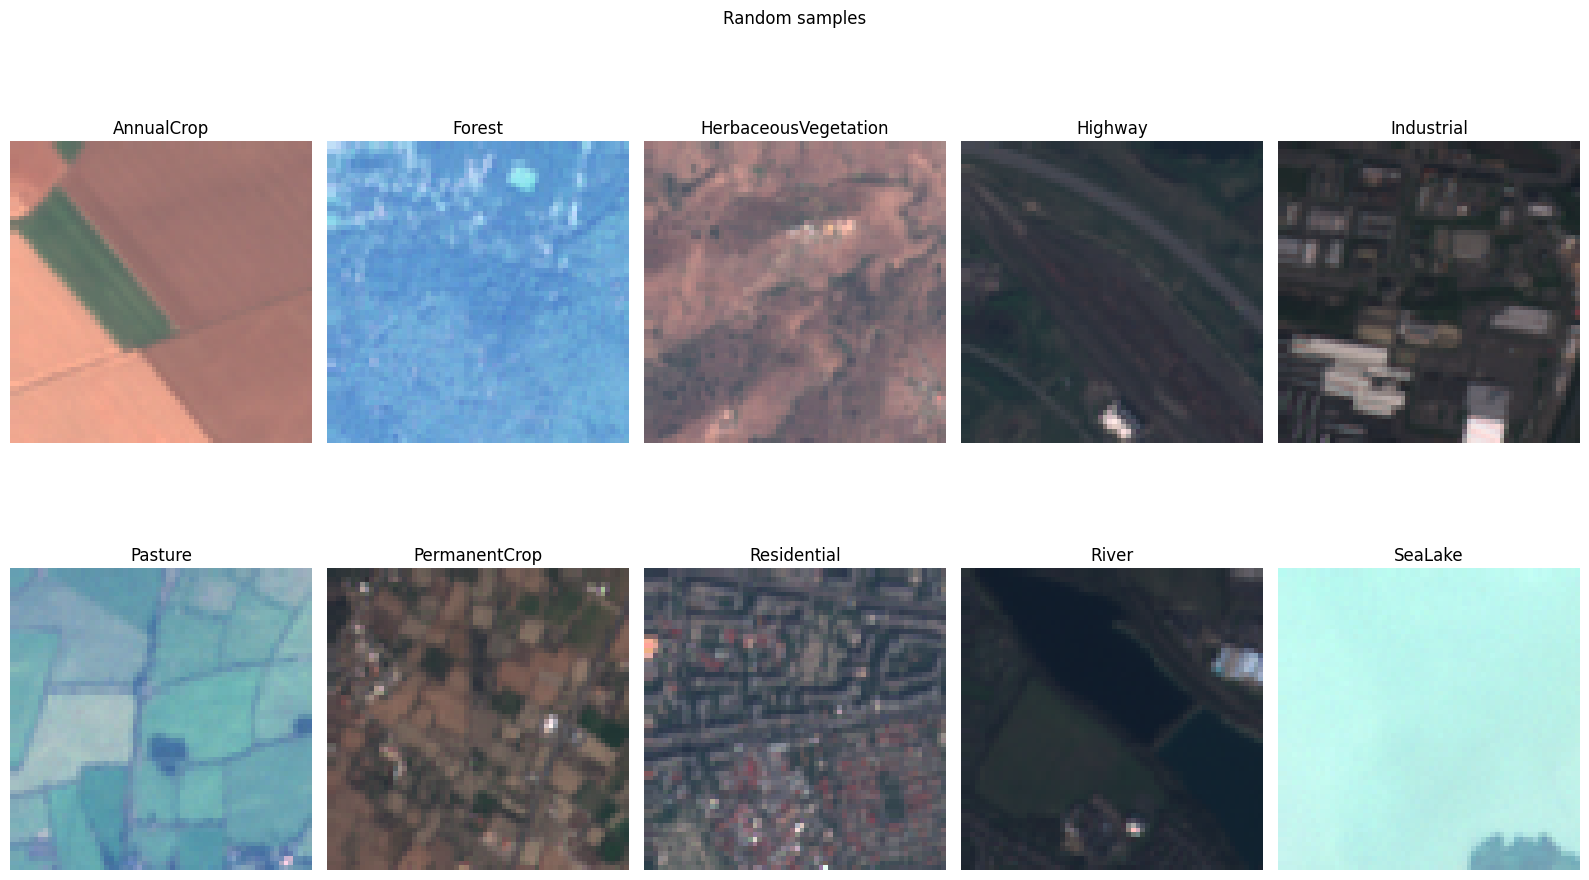

Train+Val size: 24300 Test size: 2700

=== BACKBONE: shufflenet ===
Detected feat dim: 1024 Wrapper params: 1253820


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[proj] epoch 1/50 train_loss=5.7210 train_acc=0.7584 val_loss=4.3591 val_acc=0.9150
[proj] epoch 2/50 train_loss=3.8234 train_acc=0.8654 val_loss=2.5647 val_acc=0.9364
[proj] epoch 3/50 train_loss=2.3943 train_acc=0.8885 val_loss=1.4101 val_acc=0.9487
[proj] epoch 4/50 train_loss=1.5211 train_acc=0.8929 val_loss=0.8174 val_acc=0.9525
[proj] epoch 5/50 train_loss=1.0265 train_acc=0.9000 val_loss=0.5011 val_acc=0.9545
[proj] epoch 6/50 train_loss=0.7257 train_acc=0.9060 val_loss=0.3646 val_acc=0.9542
[proj] epoch 7/50 train_loss=0.5712 train_acc=0.9140 val_loss=0.2897 val_acc=0.9561
[proj] epoch 8/50 train_loss=0.4446 train_acc=0.9224 val_loss=0.2409 val_acc=0.9580
[proj] epoch 9/50 train_loss=0.3750 train_acc=0.9260 val_loss=0.2251 val_acc=0.9558
[proj] epoch 10/50 train_loss=0.3229 train_acc=0.9314 val_loss=0.1943 val_acc=0.9569
[proj] epoch 11/50 train_loss=0.2781 train_acc=0.9358 val_loss=0.1728 val_acc=0.9613
[proj] epoch 12/50 train_loss=0.2378 train_acc=0.9447 val_loss=0.1794 val_

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[meta] epoch 1/50 train_loss=0.4113 train_acc=0.8996 val_loss=0.3112 val_acc=0.9484
[meta] epoch 2/50 train_loss=0.3070 train_acc=0.9311 val_loss=0.3191 val_acc=0.9410
[meta] epoch 3/50 train_loss=0.3386 train_acc=0.9245 val_loss=0.3580 val_acc=0.9558
[meta] epoch 4/50 train_loss=0.2801 train_acc=0.9358 val_loss=0.3141 val_acc=0.9531
[meta] epoch 5/50 train_loss=0.1730 train_acc=0.9536 val_loss=0.3167 val_acc=0.9558
[meta] epoch 6/50 train_loss=0.1313 train_acc=0.9673 val_loss=0.3480 val_acc=0.9578
Early stopping meta

=== 5-Fold CV: Fold 1/5 ===
[ensemble] epoch 1/50 train_loss=0.6443 train_acc=0.8476 val_loss=0.1910 val_acc=0.9438
[ensemble] epoch 2/50 train_loss=0.3858 train_acc=0.9056 val_loss=0.1738 val_acc=0.9486
[ensemble] epoch 3/50 train_loss=0.2735 train_acc=0.9316 val_loss=0.1267 val_acc=0.9626
[ensemble] epoch 4/50 train_loss=0.2170 train_acc=0.9460 val_loss=0.1408 val_acc=0.9630
[ensemble] epoch 5/50 train_loss=0.1873 train_acc=0.9529 val_loss=0.1234 val_acc=0.9669
[ensemb

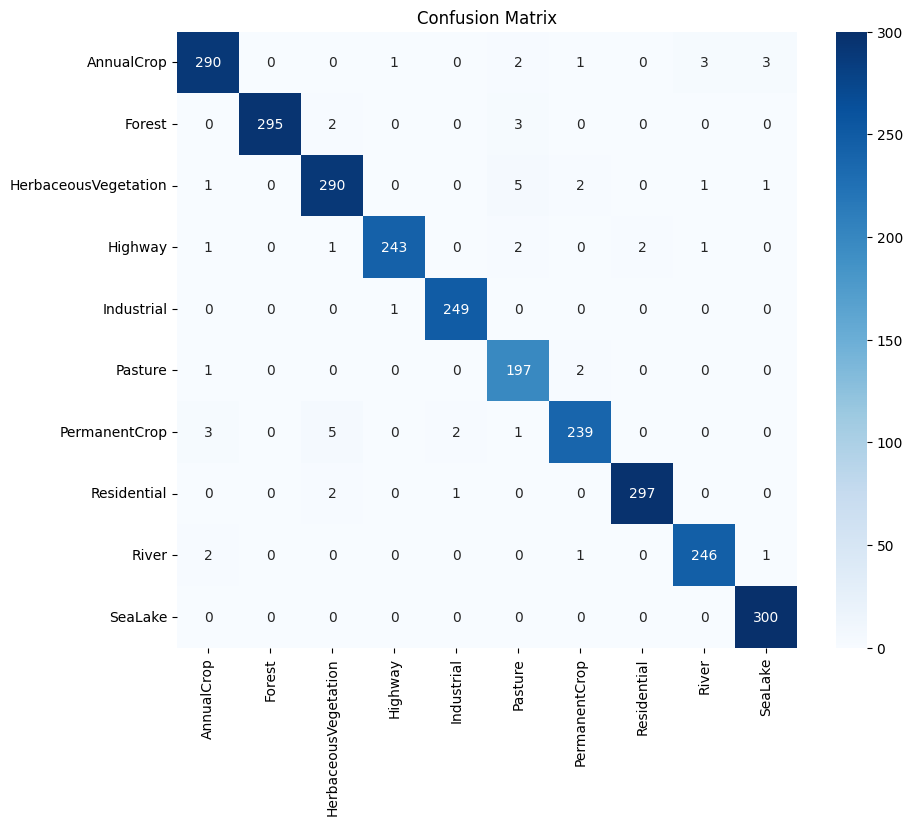

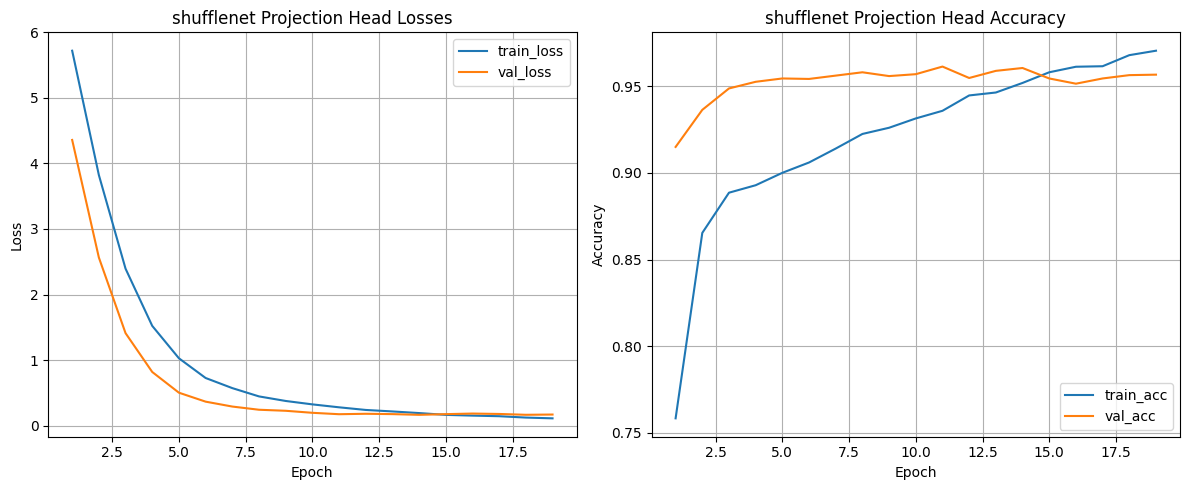

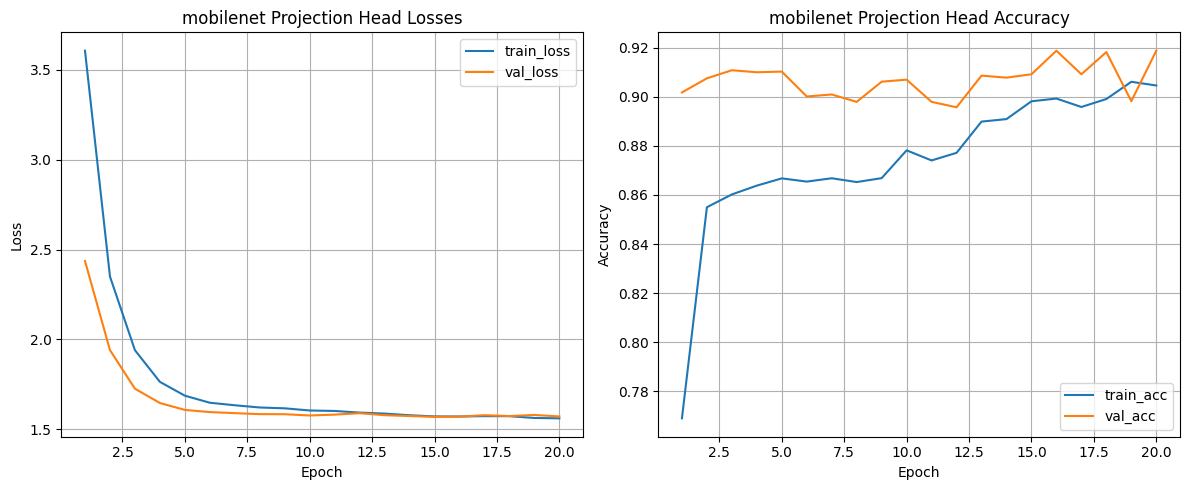

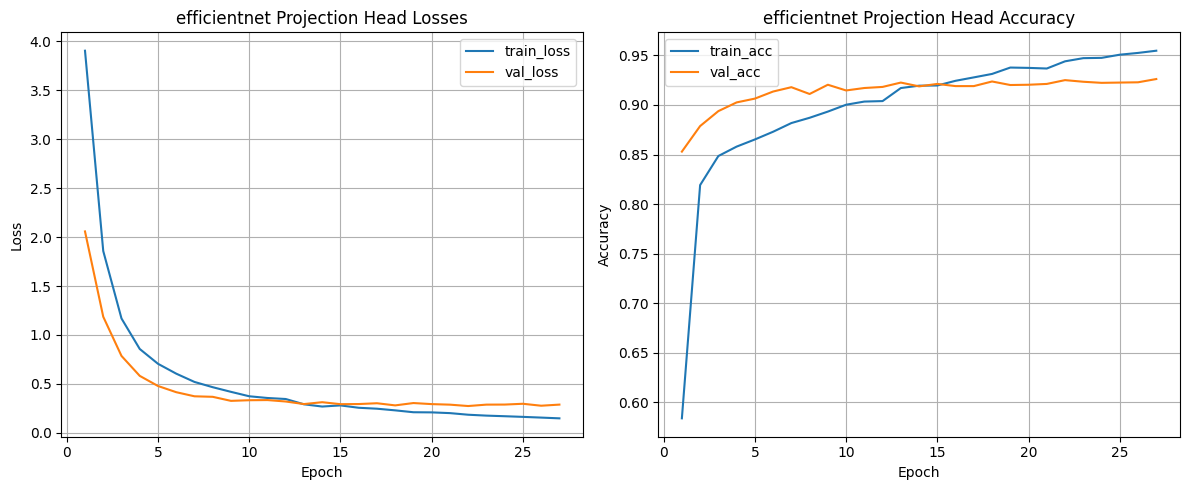

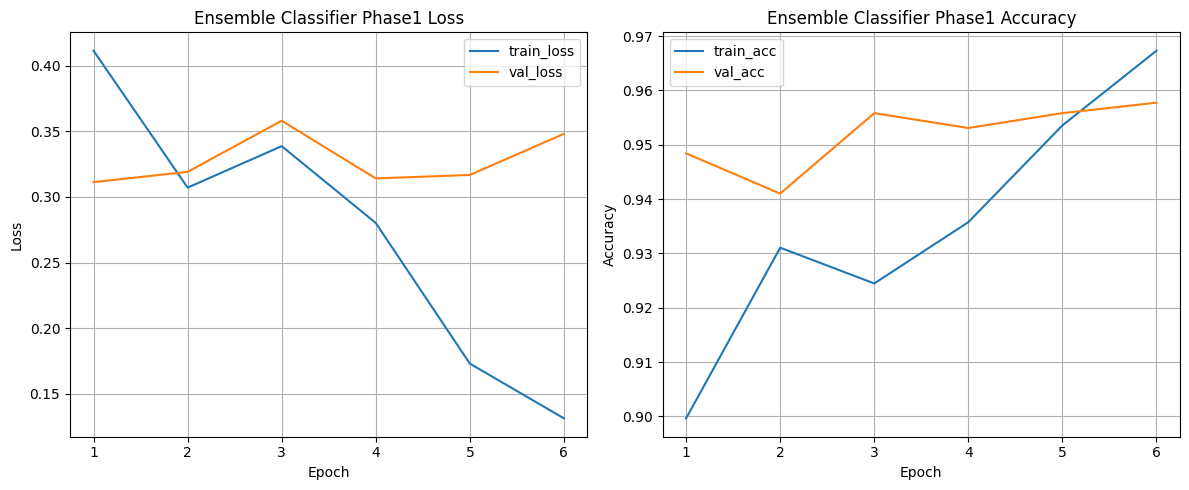

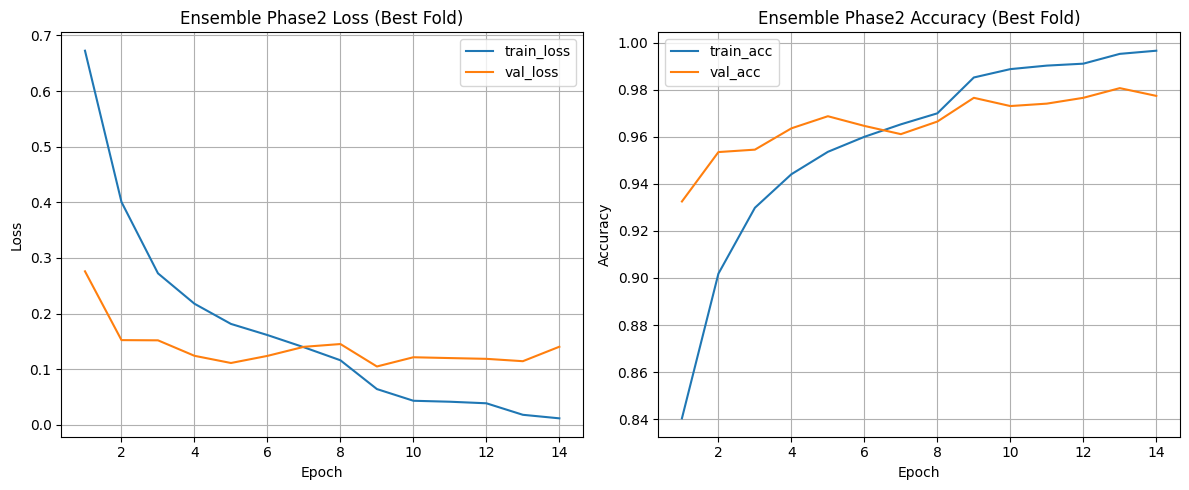

Best ensemble loaded for predictions.


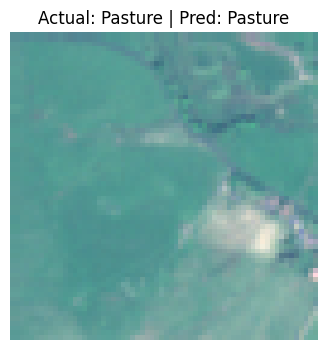

Saved sample prediction: /kaggle/working/ensemble_outputs/sample_pred_1.png


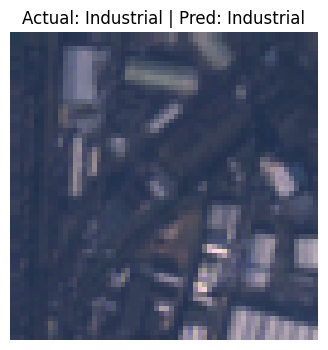

Saved sample prediction: /kaggle/working/ensemble_outputs/sample_pred_2.png


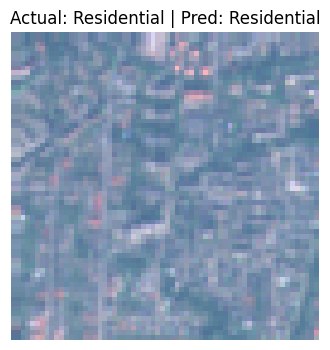

Saved sample prediction: /kaggle/working/ensemble_outputs/sample_pred_3.png


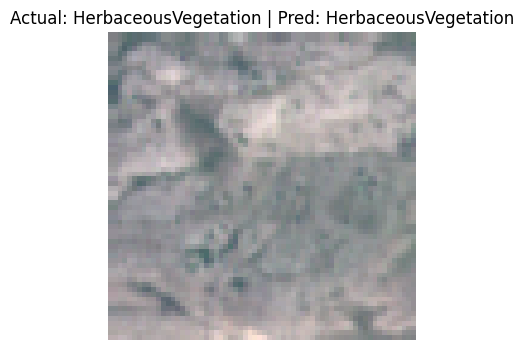

Saved sample prediction: /kaggle/working/ensemble_outputs/sample_pred_4.png


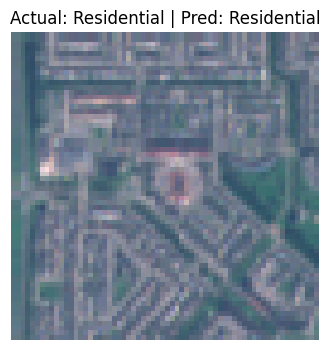

Saved sample prediction: /kaggle/working/ensemble_outputs/sample_pred_5.png


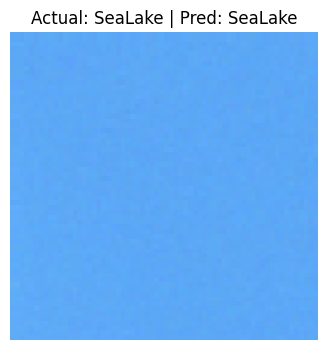

Saved sample prediction: /kaggle/working/ensemble_outputs/sample_pred_6.png


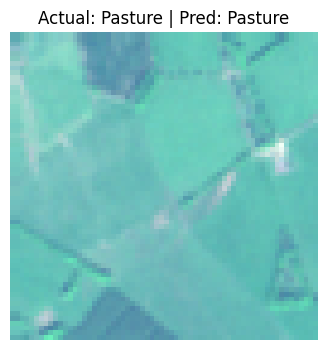

Saved sample prediction: /kaggle/working/ensemble_outputs/sample_pred_7.png
Best model loaded successfully.
Total Parameters: 10.94M
All outputs saved under: /kaggle/working/ensemble_outputs /kaggle/working/models_ensemble


In [ ]:
# ------------------ Final Pipeline ------------------
def main_pipeline():
    # For tuning: Create SMALL dataset
    ds_tuning = LandcoverDataset(DATAPATH, CLASSES, limit_per_class=TUNING_LIMIT_PER_CLASS, transform=None)
    print("Tuning samples:", len(ds_tuning))

    # Split for tuning
    labels_tuning = [ds_tuning.samples[i]['Y'] for i in range(len(ds_tuning))]
    trainval_idx_tuning, test_idx_tuning = train_test_split(list(range(len(ds_tuning))), test_size=0.1, stratify=labels_tuning, random_state=SEED)
    trainval_subset_tuning = Subset(ds_tuning, trainval_idx_tuning)

    # Optuna on small data
    study = optuna.create_study(direction="maximize")
    print("Optuna trials:", N_TRIALS)
    study.optimize(lambda t: optuna_objective(t, trainval_subset_tuning), n_trials=N_TRIALS)
    print("Optuna best params:", study.best_params)

    best = study.best_params
    lr = best.get("lr", 1e-3)
    weight_decay = best.get("weight_decay", 1e-6)
    batch_size = best.get("batch_size", 16)
    meta_dropout = best.get("meta_dropout", 0.3)

    # For final: Create FULL dataset
    ds_full = LandcoverDataset(DATAPATH, CLASSES, limit_per_class=FINAL_LIMIT_PER_CLASS, transform=None)
    print("Full samples:", len(ds_full))
    display_random_images(DATAPATH, CLASSES)

    # Split on full data
    labels_all = [ds_full.samples[i]['Y'] for i in range(len(ds_full))]
    trainval_idx, test_idx = train_test_split(list(range(len(ds_full))), test_size=0.1, stratify=labels_all, random_state=SEED)
    trainval_subset = Subset(ds_full, trainval_idx)
    test_subset = Subset(ds_full, test_idx)
    print("Train+Val size:", len(trainval_subset), "Test size:", len(test_subset))

    # Loaders for proj training
    labels_tv = [trainval_subset[i][1] for i in range(len(trainval_subset))]
    tr_idx, val_idx = train_test_split(list(range(len(trainval_subset))), test_size=0.15, stratify=labels_tv, random_state=SEED)
    train_sub = Subset(trainval_subset.dataset, [trainval_subset.indices[i] for i in tr_idx])
    val_sub = Subset(trainval_subset.dataset, [trainval_subset.indices[i] for i in val_idx])
    train_sub.dataset.transform = train_transform  # Apply augmentation
    val_sub.dataset.transform = lambda x: x
    train_loader = DataLoader(train_sub, batch_size=batch_size, shuffle=True, collate_fn=custom_collate, num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(val_sub, batch_size=batch_size, shuffle=False, collate_fn=custom_collate, num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())

    # Loaders for extraction
    trainval_noaug = Subset(trainval_subset.dataset, trainval_subset.indices)
    trainval_noaug.dataset.transform = lambda x: x
    trainval_loader = DataLoader(trainval_noaug, batch_size=batch_size, shuffle=False, collate_fn=custom_collate, num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())
    test_subset.dataset.transform = lambda x: x
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate, num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())

    backbone_names = ["shufflenet", "mobilenet", "efficientnet"]
    feats_trainval, feats_test = [], []
    proj_histories = {}

    # Train projection heads
    for name in backbone_names:
        print("\n=== BACKBONE:", name, "===")
        base, feat_dim = build_feature_extractor(name, device=DEVICE)  # Fixed: Capture feat_dim
        wrapper = BackboneProj(base).to(DEVICE)  # No PROJ_DIM
        print("Detected feat dim:", feat_dim, "Wrapper params:", count_params(wrapper))
        wrapper, train_losses, val_losses, train_accs, val_accs = train_proj_head(wrapper, train_loader, val_loader, epochs=EPOCHS_FINAL, lr=lr, weight_decay=weight_decay, patience=EARLY_STOPPING_PATIENCE)
        proj_histories[name] = {'train_loss': train_losses, 'val_loss': val_losses, 'train_acc': train_accs, 'val_acc': val_accs}
        f_tr, y_tr = extract_features(wrapper, trainval_loader)
        f_te, y_te = extract_features(wrapper, test_loader)
        feats_trainval.append(f_tr)
        feats_test.append(f_te)
        torch.save(wrapper.state_dict(), os.path.join(MODEL_DIR, f"{name}_wrapper_final.pth"))
        del base, wrapper
        torch.cuda.empty_cache()

    # Stack features
    X_trainval = np.concatenate(feats_trainval, axis=1)
    X_test = np.concatenate(feats_test, axis=1)
    print("Stacked shapes:", X_trainval.shape, X_test.shape)

    # Train/val split for meta
    tr_idx_meta, val_idx_meta = train_test_split(list(range(len(X_trainval))), test_size=0.15, stratify=y_tr, random_state=SEED)
    X_meta_tr, y_meta_tr = X_trainval[tr_idx_meta], y_tr[tr_idx_meta]
    X_meta_val, y_meta_val = X_trainval[val_idx_meta], y_tr[val_idx_meta]

    # Phase 1: Train meta classifier only
    meta = MetaNet(in_dim=X_trainval.shape[1], n_classes=len(CLASSES), dropout=meta_dropout)
    meta, meta_train_losses, meta_val_losses, meta_train_accs, meta_val_accs = train_meta(meta, X_meta_tr, y_meta_tr, X_meta_val, y_meta_val, epochs=EPOCHS_FINAL, batch_size=batch_size, lr=lr, weight_decay=weight_decay, patience=EARLY_STOPPING_PATIENCE)
    torch.save(meta.state_dict(), os.path.join(MODEL_DIR, "meta_phase1.pth"))

    # Phase 2: 5-Fold CV for ensemble fine-tuning
    k_folds = 5
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=SEED)
    best_avg_val_acc = 0
    best_model_state = None
    best_ensemble_train_losses, best_ensemble_val_losses = [], []
    best_ensemble_train_accs, best_ensemble_val_accs = [], []
    fold_val_accs = []

    for fold, (tr_idx_fold, val_idx_fold) in enumerate(kf.split(range(len(trainval_subset)))):
        print(f"\n=== 5-Fold CV: Fold {fold+1}/{k_folds} ===")
        train_sub_fold = Subset(trainval_subset.dataset, [trainval_subset.indices[i] for i in tr_idx_fold])
        val_sub_fold = Subset(trainval_subset.dataset, [trainval_subset.indices[i] for i in val_idx_fold])
        train_sub_fold.dataset.transform = train_transform
        val_sub_fold.dataset.transform = lambda x: x
        train_loader_fold = DataLoader(train_sub_fold, batch_size=batch_size, shuffle=True, collate_fn=custom_collate, num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())
        val_loader_fold = DataLoader(val_sub_fold, batch_size=batch_size, shuffle=False, collate_fn=custom_collate, num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())

        # Reload wrappers and meta for each fold
        wrappers = []
        for name in backbone_names:
            base, feat_dim = build_feature_extractor(name, device=DEVICE)
            wrapper = BackboneProj(base).to(DEVICE)
            wrapper.load_state_dict(torch.load(os.path.join(MODEL_DIR, f"{name}_wrapper_final.pth")))
            wrappers.append(wrapper)
        meta = MetaNet(in_dim=X_trainval.shape[1], n_classes=len(CLASSES), dropout=meta_dropout)
        meta.load_state_dict(torch.load(os.path.join(MODEL_DIR, "meta_phase1.pth")))
        ensemble = FinalEnhancedEnsembleModel(wrappers, meta).to(DEVICE)

        # Unfreeze all for fine-tuning
        for p in ensemble.parameters():
            p.requires_grad = True
        low_lr = lr / 10  # Very low learning rate
        ensemble, ensemble_train_losses, ensemble_val_losses, ensemble_train_accs, ensemble_val_accs = train_ensemble(ensemble, train_loader_fold, val_loader_fold, epochs=EPOCHS_FINAL, lr=low_lr, weight_decay=weight_decay, patience=EARLY_STOPPING_PATIENCE)

        # Save fold-specific model
        for i, name in enumerate(backbone_names):
            torch.save(ensemble.wrappers[i].state_dict(), os.path.join(MODEL_DIR, f"{name}_wrapper_phase2_fold{fold+1}.pth"))
        torch.save(ensemble.meta.state_dict(), os.path.join(MODEL_DIR, f"meta_phase2_fold{fold+1}.pth"))

        # Track best
        fold_val_acc = max(ensemble_val_accs)
        fold_val_accs.append(fold_val_acc)
        if fold_val_acc > best_avg_val_acc:
            best_avg_val_acc = fold_val_acc
            best_model_state = ensemble.state_dict()
            best_ensemble_train_losses = ensemble_train_losses
            best_ensemble_val_losses = ensemble_val_losses
            best_ensemble_train_accs = ensemble_train_accs
            best_ensemble_val_accs = ensemble_val_accs

    avg_val_acc = np.mean(fold_val_accs)
    print(f"Average Validation Accuracy across {k_folds} folds: {avg_val_acc:.4f}")

    # Save the best full ensemble model from CV
    torch.save(best_model_state, "/kaggle/working/landcover_model_best.pth")

    # Evaluate on test using the best model
    ensemble.load_state_dict(best_model_state)
    ensemble.eval()
    preds_list, probs_list, y_te_list = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            if batch is None:
                continue
            x, y, _ = batch
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = ensemble(x)
            preds = logits.argmax(dim=1).cpu().numpy()
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            preds_list.append(preds)
            probs_list.append(probs)
            y_te_list.append(y.cpu().numpy())
    preds = np.concatenate(preds_list)
    probs = np.concatenate(probs_list)
    y_te = np.concatenate(y_te_list)

    # Compute metrics
    acc = accuracy_score(y_te, preds)
    prec = precision_score(y_te, preds, average='macro', zero_division=0)
    rec = recall_score(y_te, preds, average='macro', zero_division=0)
    f1 = f1_score(y_te, preds, average='macro', zero_division=0)
    try:
        roc_auc = roc_auc_score(y_te, probs, multi_class='ovr')
    except Exception:
        roc_auc = float('nan')

    # Save metrics
    metrics_path = os.path.join(SAVE_DIR, "final_metrics.txt")
    with open(metrics_path, "w") as f:
        f.write("=== Ensemble final metrics ===\n")
        f.write(f"Optuna best params: {study.best_params}\n")
        f.write(f"Test Accuracy: {acc:.4f}\n")
        f.write(f"Precision (macro): {prec:.4f}\n")
        f.write(f"Recall (macro): {rec:.4f}\n")
        f.write(f"F1 (macro): {f1:.4f}\n")
        f.write(f"ROC-AUC (ovr): {roc_auc}\n")
    print("Metrics saved to:", metrics_path)
    print("Final test metrics -> Acc: {:.4f}, Prec: {:.4f}, Rec: {:.4f}, F1: {:.4f}, ROC_AUC: {:.4f}".format(acc, prec, rec, f1, roc_auc if not np.isnan(roc_auc) else 0.0))

    # Confusion matrix
    cm = confusion_matrix(y_te, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.savefig(os.path.join(SAVE_DIR, "confusion_matrix.png"))
    plt.show()
    plt.close()

    # Plot backbone loss and accuracy curves
    for name, hist in proj_histories.items():
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(hist['train_loss'])+1), hist['train_loss'], label='train_loss')
        plt.plot(range(1, len(hist['val_loss'])+1), hist['val_loss'], label='val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{name} Projection Head Losses')
        plt.legend()
        plt.grid(True)
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(hist['train_acc'])+1), hist['train_acc'], label='train_acc')
        plt.plot(range(1, len(hist['val_acc'])+1), hist['val_acc'], label='val_acc')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f'{name} Projection Head Accuracy')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(SAVE_DIR, f"{name}_curves.png"))
        plt.show()
        plt.close()

    # Plot meta phase1 loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(meta_train_losses)+1), meta_train_losses, label='train_loss')
    plt.plot(range(1, len(meta_val_losses)+1), meta_val_losses, label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Ensemble Classifier Phase1 Loss')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(meta_train_accs)+1), meta_train_accs, label='train_acc')
    plt.plot(range(1, len(meta_val_accs)+1), meta_val_accs, label='val_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Ensemble Classifier Phase1 Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, "meta_phase1_curves.png"))
    plt.show()
    plt.close()

    # Plot ensemble phase2 loss and accuracy (from best fold)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(best_ensemble_train_losses)+1), best_ensemble_train_losses, label='train_loss')
    plt.plot(range(1, len(best_ensemble_val_losses)+1), best_ensemble_val_losses, label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Ensemble Phase2 Loss (Best Fold)')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(best_ensemble_train_accs)+1), best_ensemble_train_accs, label='train_acc')
    plt.plot(range(1, len(best_ensemble_val_accs)+1), best_ensemble_val_accs, label='val_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Ensemble Phase2 Accuracy (Best Fold)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, "ensemble_phase2_curves.png"))
    plt.show()
    plt.close()

    # Sample predictions
    cpu_wrappers = []
    for name in backbone_names:
        base, feat_dim = build_feature_extractor(name, device='cpu')
        wrapper = BackboneProj(base).to('cpu').eval()
        cpu_wrappers.append(wrapper)
    cpu_meta = MetaNet(in_dim=3584, n_classes=len(CLASSES), dropout=0.34899)  # Use the tuned dropout
    cpu_ensemble = FinalEnhancedEnsembleModel(cpu_wrappers, cpu_meta).to('cpu').eval()
    cpu_ensemble.load_state_dict(torch.load("/kaggle/working/landcover_model_best.pth", map_location='cpu'))
    print("Best ensemble loaded for predictions.")
    
    test_subset.dataset.transform = lambda x: x
    test_loader_paths = DataLoader(test_subset, batch_size=1, shuffle=True, collate_fn=custom_collate, num_workers=NUM_WORKERS)  # Shuffle for random samples
    sample_count = 0
    for batch in test_loader_paths:
        if batch is None:
            continue
        imgs, labels, paths = batch
        imgs = imgs.to('cpu')
        with torch.no_grad():
            out = cpu_ensemble(imgs)
            pred = out.argmax(dim=1).cpu().numpy()[0]
        actual = labels.numpy()[0]
        img_path = paths[0]
        try:
            with rasterio.open(img_path) as src:
                rgb = src.read([4,3,2]).astype(np.float32)
                mx = rgb.max() if rgb.max() > 0 else 1.0
                rgb = np.clip(rgb/mx, 0, 1)
                plt.figure(figsize=(4,4))
                plt.imshow(rgb.transpose(1,2,0))
                plt.title(f"Actual: {CLASSES[actual]} | Pred: {CLASSES[pred]}")
                plt.axis('off')
                save_p = os.path.join(SAVE_DIR, f"sample_pred_{sample_count+1}.png")
                plt.savefig(save_p)
                plt.show()
                plt.close()
                print("Saved sample prediction:", save_p)
        except Exception as e:
            print("Could not read image for display:", img_path, e)
        sample_count += 1
        if sample_count >= N_SAMPLE_PRED:
            break

    wrappers_for_load = []
    for name in backbone_names:
        base, feat_dim = build_feature_extractor(name, device=DEVICE)
        wrapper = BackboneProj(base).to(DEVICE)
        wrappers_for_load.append(wrapper)
    meta_for_load = MetaNet(in_dim=X_test.shape[1], n_classes=len(CLASSES), dropout=meta_dropout)
    model = FinalEnhancedEnsembleModel(wrappers_for_load, meta_for_load).to(DEVICE)
    model.load_state_dict(torch.load("/kaggle/working/landcover_model_best.pth"))
    model.eval()
    print("Best model loaded successfully.")

    # Calculate total number of parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total Parameters: {total_params / 1e6:.2f}M")

    print("All outputs saved under:", SAVE_DIR, MODEL_DIR)

# Run pipeline
if __name__ == "__main__":
    main_pipeline()